#  Introduction

In this tutorial we will be using PostgreSQL and psycopg to work with and analyze same databases. We will then be working with matplotlib and seaborn to provide visualizations of the given datasets. Before we dive into using these various modules, it is important to understand what each of these modules do and how we can use them!

Note that the initial part of this tutorial will require setting of PostgreSQL and require some command line work  although the late portions will all be in python!

`PostgreSQL` is a popular relational database management system that supports a large part of the SQL standard 
and offers many features such as triggers and foreign keys. PostgreSQL is used as the primary data store or 
data warehouse for many web, mobile, geospatial, and analytics applications.


`Psycopg` is the most popular PostgreSQL database adapter for Python. This module will allow us to interface with PostegreSQL.

Finally, `matplotlib` is a python data visualization library that will allow us to provide graphs of the data we will query. The `seaborn` package is built on top of the matplotlib package to provide more attractive visualizations of the data.

# PostgreSQL Set Up


PostgreSQL can be set up in the following manner on MacOS.  

The simplest option is to download the Postgres.app for MacOS (http://postgresapp.com).  Double clicking the app will start Postgres. You will see an icon for an elephant on your menu bar. Right clicking the icon gives various options including quitting the app.

To run postgres from a terminal window you need to add the installation path
to your PATH environment variable. Step-3 of the set of installation instructions at
https://postgresapp.com/ suggests changing /etc/paths.d . 

Do not follow this step as it is easier to adjust the PATH environment variable as shown below:

From a terminal window type:

`% touch ~/.bash_profile`

`% open ~/.bash_profile`

This will open the file .bash_profile in your default editor. Add the following lines to the
very end of the .bash_profile file:

export PATH=/Applications/Postgres.app/Contents/Versions/latest/bin:$PATH

The path /Applications/Postgres.app/Contents/Versions/latest/bin/ should be the
a similar path that appears when you open a psql terminal window via the elephant
icon on your MacOS menu bar. Save the file .bash_profile and exit the editor. 
Close any open terminal windows and open a new terminal window. If you now do:

`% which psql`

you should see the absolute path to the executable
/Applications/Postgres.app/Contents/Versions/latest/bin/psql

Windows users can set up Postgres in a similar fashion using the following link https://www.postgresql.org/download/windows/

To check if the set up is working we can make the following command on terminal


`% psql -U postgres -d postgres`

If the set up is correct you should see the prompt 

`postgres=#`

Exit postgres by using `\q` at the command line.

# Installing the libraries

Before we begin, we must install the following python libraries using `pip`

`$ pip install matplotlib`

`$ pip install psycopg2`

`$ pip install seaborn`

After running the above installs the following comands should work for you!

Note: we are inlining the matplotlib graphs so that they will be produced in the notebook instead of as a popping out.

In [1]:
import matplotlib.pyplot as plt

import seaborn


%matplotlib inline
import psycopg2 as pg2
import csv

# Loading Data

We can now begin coding with by starting up postgres.

In [2]:


%reload_ext sql
%sql postgres://postgres@localhost/postgres


'Connected: postgres@postgres'

Now we can establish a connection by specifying the user and using a connect() method. This method takes in a sequence of parameters that the psycopg library uses to connect to the Postgres server. The connect method creates a client session with the database server that allows us to issue commands to it.


We also will be setting autocommit to be true. By defaault in psycopg2, no data manipulation is saved if the commit() function is not called afterwards. By setting the connection instance to autocommit, we will not be required to save after each transaction. 

We will also use the connection object to create a cursor object. This cursor will allow us to use python code to execute commands on PostgreSQL through the execute method.


In [3]:
# Establish a connection by specifying the database and user
# This is the psycopg2 analog to
#   %  psql -d postgres -U isdb

con = pg2.connect(database='postgres', user='postgres')  

# if you need to specify a password use an additional keywork parameter as shown below:
# con = pg2.connect(database='postgres', user='postgres', password='YOUR PASSWORD')

con.autocommit = True

cur = con.cursor()

# CRUD functions

This example will introduce you to the CRUD operations in SQL and how you can perform them in Postgres. CRUD stands for create, read, update, and delete. These operations are the 4 persistent functions of database. The following example will walk you through how each of these functions can be performed.

Let us begin with some simple examples to see how this works. First we will begin by creating a table that details some students and their GPA's.

Notice the structure of this table. Each column on the left is the name of the column we are creating while on the left is the data type that this column will be storing. 

Now we can begin working with SQL commands through the execute() method. This function takes in a string of SQL code as a parameter and uses it to work with the database.

In [4]:
sql_grades_drop_create = '''
  DROP TABLE IF EXISTS Grades;
  
  CREATE TABLE Grades (
    id     int PRIMARY KEY,   
    name   text,
    GPA    float
    )
'''
cur.execute(sql_grades_drop_create)

Now that we have created a table, we can load data into it through the SQL INSERT INTO command. When inputting data it is necessary that the data types inputted match the data types specified when the table is first created. In the below example, uncommenting the last line will raise an error (try it out yourself).

In [5]:
sql_insert = '''
  INSERT INTO Grades (id, name, GPA)
       VALUES 
        (1,'Sam',2.87),
        (2,'Laura',3.33),
        (3,'Denise',2.31),
        (4,'John',3.23),
        (5,'Nathan',3.75),
        (6,'Gisele',3.5),
        (7,'Cindy',3.8),
        (8,'Phillip',4.0)   
'''



cur.execute(sql_insert)
#cur.execute(sql_bad_insert)

Let us write a few simple python functions to see our progress. We will be using the fetchall() method to retrieve data from any existing table related to the cursor attribute. We can loop through this fetchall object to read the table. 

In [6]:
def show_all_grades():
    cur.execute("select * from Grades")
    rows = cur.fetchall()
    for row in rows:
        print(row)
        
show_all_grades()


(1, 'Sam', 2.87)
(2, 'Laura', 3.33)
(3, 'Denise', 2.31)
(4, 'John', 3.23)
(5, 'Nathan', 3.75)
(6, 'Gisele', 3.5)
(7, 'Cindy', 3.8)
(8, 'Phillip', 4.0)


Now let us try updating our table. We can use the executemany() command here to perform multiple changes to the relation table at once

In [7]:
def updateTable(changes):
    sql_update_query = """Update Grades SET GPA = %s where id = %s"""
    cur.executemany(sql_update_query, changes)
updateTable([(3.87,1), (3.0,5)])

show_all_grades()

(2, 'Laura', 3.33)
(3, 'Denise', 2.31)
(4, 'John', 3.23)
(6, 'Gisele', 3.5)
(7, 'Cindy', 3.8)
(8, 'Phillip', 4.0)
(1, 'Sam', 3.87)
(5, 'Nathan', 3.0)


A similar function could be performed to delete entries from the table as shown below.

In [8]:
def deleteTable(changes):
    sql_delete_query = """Delete FROM Grades WHERE GPA < %s"""
    cur.executemany(sql_delete_query, changes)
deleteTable([(3.0,)])
show_all_grades()

(2, 'Laura', 3.33)
(4, 'John', 3.23)
(6, 'Gisele', 3.5)
(7, 'Cindy', 3.8)
(8, 'Phillip', 4.0)
(1, 'Sam', 3.87)
(5, 'Nathan', 3.0)


We can also perform general SQL operations to the table to filter and order the data. Note that these are not permanent changes to the original table.

In [9]:

def grade_above(n):
    s = '''
    SELECT  name, gpa
    FROM Grades
    WHERE gpa > %s
    ORDER by gpa DESC;
    '''
    cur.execute(s, (n,))
    rows = cur.fetchall()
    for row in rows:
        print(row)


grade_above(3.3)

('Phillip', 4.0)
('Sam', 3.87)
('Cindy', 3.8)
('Gisele', 3.5)
('Laura', 3.33)


# Integrity Constraints

One of the biggest advantages of PostgreSQL is that we can enforce multiple constraints on our table to ensure that 
our table fits whatever constraints and checks we want on it. In this part of the tutorial, we will quickly run you over how
we can ensure the integrity of our tables. The orimary key is an example of one type of integrity constraint that prevents duplicate values allowing us to uniquely identify each row.

Let us first write an sql statement to create a table that stores products at a supermarket and information about their prices.

In [10]:
product1 = '''
  DROP TABLE IF EXISTS Product;
  
  CREATE TABLE Product (
    product_no  int PRIMARY KEY,   
    name   text,
    price  numeric,
    discounted_price numeric
    )
'''
sql_insert = '''
  INSERT INTO Product (product_no, name, price, discounted_price)
       VALUES   
        (1,'Cake',10,1),
        (2,'Pan',24,8),
        (3,'Milk',6,0)
    
'''

cur.execute(product1)
cur.execute(sql_insert)



When inputting data it is necessary that the data types inputted match the data types specified when the table is first created. In the below example, uncommenting the last line will raise an error (try it out yourself). 

We have used the primary key as an optional paramter to specify that this column cannot contain any duplicate values and hence can be used to uniquely identify any row in the table. Hence inserting a duplicate product_id as below will also raise an error.

In [11]:
sql_bad_insert = '''
  INSERT INTO Product (product_no, name, price, discounted_price)
       VALUES 
        (8,'Milk','six',0)  
'''

sql_duplicate_insert = '''
  INSERT INTO product (product_no, name, price, discounted_price)
       VALUES 
        (1,'Bread',3,1)  
'''

#cur.execute(sql_duplicate_insert)

#cur.execute(sql_bad_insert)

Look at the SQL query below. It would appear that it shouldn't fail as all the data types conform to what we set when we created the table! However, it clearly shouldn't work as the price is negative.  This is where we can use checks to help ensure more specific conditions we want for our tables. Checks specify a condition that will disallow insertions if the condition is not specified. 

The create table command below does a better job of dissallowing negative insertions. Although this table is better than our initial one, it is still not complete. There is a problem with it.

In [12]:
sql_negative_insert = '''
  INSERT INTO Product (product_no, name, price, discounted_price)
       VALUES 
        (5,'Milk',-3,0)  
'''

f ='''CREATE TABLE products (
    product_no integer,
    name text,
    price numeric,
    CHECK (price > 0),
    discounted_price numeric,
    CHECK (discounted_price > 0)
);'''

In the above table, if the discounted price where to be greater than the initial price, this would lead to a negative price. This is something we don't want to happen. Constraints work similar to checks but can work accross multiple columns in a table. The below table shows an example.

In [13]:
t ='''

    DROP TABLE IF EXISTS Product;
    CREATE TABLE product (
    product_no integer PRIMARY KEY,
    name text,
    price numeric,
    CHECK (price > 0),
    discounted_price numeric,
    CHECK (discounted_price > 0),
    CONSTRAINT valid_discount CHECK (price > discounted_price)
);'''

cur.execute(t)



The below commands will now fail when uncommented due to out new checks! Uncomment each of the lines below to see the type of error.

In [14]:

sql_highDiscount_insert = '''
  INSERT INTO product (product_no, name, price, discounted_price)
       VALUES 
        (6,'Bread',4,5)  
'''

#cur.execute(sql_negative_insert)
#cur.execute(sql_highDiscount_insert)

# Example #1 NFL Suspension Data

Now that we know the basics, we can try a little more of an interesting example that deals with real life NFL player suspensions data. Psycopg2 has a useful copy_from() functionality that allows us to easily read and load data from a CSV into an existing relational table. When calling this function it is important to specify that the delimiter is a comma as otherwise the function takes a tab to be the default delimiter. 

In [15]:
sql_nfl_create = '''
  DROP TABLE IF EXISTS suspensions;
  
  CREATE TABLE suspensions (
    name     text,   
    team   text,
    games    text,
    category text,
    description text,
    year int
    )
'''

cur.execute(sql_nfl_create)

with open('nfl-suspensions-data.csv') as nfldata:
    cur.copy_from(nfldata, 'suspensions',sep=",", columns=('name', 'team', 'games', 'category', 'description', 'year'))

def show_all_suspensions():
    cur.execute("select * from Suspensions")
    rows = cur.fetchall()
    for row in rows:
        print(row)
show_all_suspensions()

('F. Davis', 'WAS', 'Indef.', 'Substance abuse repeated offense', 'Marijuana-related', 2014)
('J. Blackmon', 'JAX', 'Indef.', 'Substance abuse repeated offense', '', 2014)
('L. Brazill', 'IND', 'Indef.', 'Substance abuse repeated offense', '', 2014)
('T. Jackson', 'WAS', 'Indef.', 'Substance abuse repeated offense', '', 2014)
('M. Hapes', 'NYG', 'Indef.', 'Personal conduct', 'Gambling-related', 1946)
('R. Rice', 'BAL', 'Indef.', 'Personal conduct', 'Domestic violence', 2014)
('F. Filchock', 'NYG', '36', 'Personal conduct', 'Gambling-related', 1947)
('J. Jolly', 'GB', '32', 'Substance abuse repeated offense', 'Arrest felony possession of codeine', 2010)
('O. Thurman', 'CIN', '32', 'Substance abuse repeated offense', '', 2008)
('A. Jones', 'TEN', '20', 'Personal conduct', 'Multiple arrests', 2007)
('A. Schlichter', 'IND', '16', 'Personal conduct', 'Gambling-related', 1983)
('D. Stallworth', 'NE', '16', 'Personal conduct', 'DUI manslaughter', 2009)
('W. Bryant', 'ARI', '16', 'Substance ab

Now let us perform some table operations to visualize some interesting trends about the above data. First let us visualize the top 10 teams with the most suspensions and how suspension numbers have changed over the years.

To visualize the trends we will be using matplotlib. This .bar() method will draw a bar plot while the .plot() function will draw a line graph.

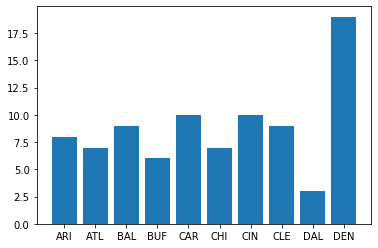

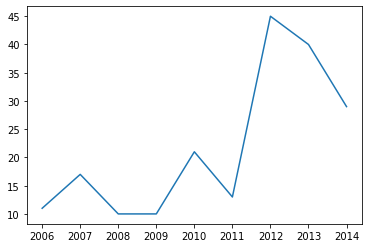

In [16]:
def plotBar():
    groupTeams = '''
    SELECT team, count(team)
    FROM suspensions
    GROUP BY team
    ORDER BY team ASC
    LIMIT 10
    '''
    
    cur.execute(groupTeams)
    rows = cur.fetchall()

    
    teams = [team for (team, count) in rows]
    counts = [count for (team, count) in rows]
    
    plt.bar(teams, counts)
    plt.show()
    

def plotTrend():
    groupYears = '''
    SELECT year, count(year)
    FROM suspensions
    WHERE year > 2005
    GROUP BY year
    ORDER BY year ASC
    '''
    cur.execute(groupYears)
    rows = cur.fetchall()

    
    years = [year for (year, count) in rows]
    counts = [count for (year, count) in rows]
    
    plt.plot(years, counts)
    plt.show()

plotBar()
plotTrend()




Looks good! Now let us see how we can map the different types of suspension categories by year. We can once use sql commands with combination of list comprehensions to do this.

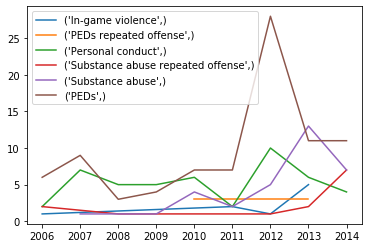

In [17]:


def getCategories():
    #gets names of all possible categories
    categorySearch = '''
    SELECT category
    FROM suspensions
    GROUP BY category
    '''
    cur.execute(categorySearch)
    rows = cur.fetchall()
    return [category for category in rows]
    


def plotCategoryTrend(category):
    # plots each category against year
    groupTeams = '''
    SELECT year, count(year)
    FROM suspensions
    WHERE year > 2005 and category = %s
    GROUP BY year
    ORDER BY year ASC
    ''' 
    
    cur.execute(groupTeams, [category])
    rows = cur.fetchall() 
    years = [year for (year, count) in rows]
    counts = [count for (year, count) in rows]
    plt.plot(years, counts)

def plotFinalCategory():
    # plots all categories
    categories = getCategories()
    for c in categories:
        plotCategoryTrend(c[0])
    plt.legend(categories)
    plt.show()
   
plotFinalCategory()

# Other Sources

You can learn more about psycopg2, PostgreSQL and relational databases through the following links!

Relational Databases:

https://dev.to/lmolivera/everything-you-need-to-know-about-relational-databases-3ejl


PostgreSQL:

https://www.postgresql.org/docs/

https://bytescout.com/blog/postgresql-advanced-queries.html

Psycopg2:

https://stackabuse.com/working-with-postgresql-in-python/

http://initd.org/psycopg/docs/

    


Sources: 

NFL Data https: //github.com/fivethirtyeight/data
         
PostgreSQL Download 67262 Notes